#**ESMFold**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1
- See [experimental notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/ESMFold_advanced.ipynb) for more advanced options (like sampling).

#### **Colab Limitations**
- For short monomeric proteins under the length 400, consider using [ESMFold API](https://esmatlas.com/resources?action=fold) (no need for GPU, super fast!)
- On Tesla T4 (typical free colab GPU), max total length ~ 900

In [ ]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)
version = "1" # @param ["0", "1"]
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 548 ms, sys: 65.1 ms, total: 613 ms
Wall time: 3min 47s


In [ ]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 68
ptm: 0.816 plddt: 90.509
CPU times: user 12.1 s, sys: 6.09 s, total: 18.2 s
Wall time: 18.1 s


In [ ]:

# ## Versión Optimizada para Extraer Solo pLDDT
# Cambios clave:
# 1. Eliminación de outputs innecesarios (PDB, PAE)
# 2. Almacenamiento eficiente de pLDDT
# 3. Formato comprimido para grandes datasets

# %%
#@title ## Configuración
fasta_path = "/content/immuno_sequences.fasta"  # Sube tu archivo FASTA
output_dir = "pLDDT_results"               # Directorio de salida
batch_size = 5                             # Procesamiento individual
max_sequence_length = 1000                 # Ajustar según tu GPU

# ## Función Modificada de Procesamiento
# Extracción directa del pLDDT

# %%

    # Nueva función para generar batches
def process_fasta_pLDDT(fasta_path, output_dir):
    from Bio import SeqIO
    from tqdm import tqdm
    import pandas as pd
    import hashlib

    def batch_generator(records, batch_size=4):
        for i in range(0, len(records), batch_size):
            yield records[i:i + batch_size]

    records = list(SeqIO.parse(fasta_path, "fasta"))
    os.makedirs(output_dir, exist_ok=True)

    df = pd.DataFrame(columns=["ID", "Longitud", "pLDDT_mean", "pLDDT_file"])

    if "model" not in globals():
        global model
        model = torch.load(model_name, weights_only=False)
        model.eval().cuda().requires_grad_(False)
        model.set_chunk_size(128 if max_sequence_length <= 700 else 64)

    batch_size = 30
    import math
    total_batches = math.ceil(len(records) / batch_size)
    for batch in tqdm(
        batch_generator(records, batch_size),
        desc="Procesando batches",
        total=total_batches,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} ETA: {remaining} [{rate_fmt}]"
    ):
        try:
            # Paso 1: Extraer y filtrar datos manteniendo IDs
            sequences = [(rec.id.split("|")[0], str(rec.seq).upper()) for rec in batch]
            valid_data = [(seq_id, seq) for seq_id, seq in sequences if 0 < len(seq) <= max_sequence_length]

            if not valid_data:
                continue  # Saltar lotes vacíos

            valid_seqs = [seq for _, seq in valid_data]

            # Paso 2: Procesamiento batch
            with torch.no_grad():
                output = model.infer(valid_seqs, num_recycles=3)
                plddts = output["plddt"][..., 1].cpu().numpy()

            # Paso 3: Guardar resultados alineados
            for (seq_id, seq), plddt in zip(valid_data, plddts):
                filename = f"{hashlib.sha256(seq.encode()).hexdigest()[:12]}_plddt.npy"
                np.save(os.path.join(output_dir, filename), plddt)

                df.loc[len(df)] = {
                    "ID": seq_id,
                    "Longitud": len(seq),
                    "pLDDT_mean": plddt.mean(),
                    "pLDDT_file": filename
                }

            del output
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error en batch: {str(e)}")
            continue

    df.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)

# ## Ejecución
# (Manteniendo solo lo esencial)

# %%

if __name__ == "__main__":
    import torch
    import numpy as np

    # Verificar GPU
    assert torch.cuda.is_available(), "Se requiere GPU"

    # Cargar modelo (ajusta la ruta)
    model_name = "esmfold_3B_v1"
    if "model" not in globals():
        model = torch.load(model_name)
        model.eval().cuda().requires_grad_(False)

    # Procesar
    process_fasta_pLDDT(fasta_path, output_dir)

    # Limpiar
    del model
    torch.cuda.empty_cache()





Procesando batches: 100%|██████████| 17/17 ETA: 00:00 [13.99s/it]


In [ ]:
from Bio import SeqIO
import pandas as pd

# ─── PARAMETROS ─────────────────────────────────────────────
FASTA_IN   = "immuno_sequences.fasta"
METADATA   = "pLDDT_results/metadata.csv"
FASTA_OUT  = "filtrado_plddt0.8.fasta"
UMBRAL     = 75
ID_COLUMN  = "ID"          # nombre exacto de la columna con el ID

# ─── 1) IDs “buenos” como STR ───────────────────────────────
df = pd.read_csv(METADATA)
print(df)
ids_validos = {str(i).strip()                # ← convierte a string
               for i in df.loc[df["pLDDT_mean"] > UMBRAL, ID_COLUMN]}
print(ids_validos)
# ─── 2) Filtrar FASTA ───────────────────────────────────────
total = seleccionadas = 0
with open(FASTA_OUT, "w") as fout:
    for rec in SeqIO.parse(FASTA_IN, "fasta"):
        total += 1
        if rec.id.strip() in ids_validos:   # ambos son str
            SeqIO.write(rec, fout, "fasta")
            seleccionadas += 1

print(f"Total: {total}  |  Seleccionadas: {seleccionadas}")
print(f"FASTA filtrado guardado en: {FASTA_OUT}")




            ID  Longitud  pLDDT_mean              pLDDT_file
0       seq_14        99   47.019260  7928934d183e_plddt.npy
1      seq_155        99   63.499220  31f0ed079843_plddt.npy
2      seq_216        99   51.442387  4bb59658e526_plddt.npy
3      seq_222        99   37.028553  121b41dc16da_plddt.npy
4      seq_270        99   62.394430  108943320ff2_plddt.npy
..         ...       ...         ...                     ...
494  seq_49680        99   89.398280  5115f31f9169_plddt.npy
495  seq_49785        99   61.381065  c79466bc03e0_plddt.npy
496  seq_49843        99   43.312344  95e33ad3a31c_plddt.npy
497  seq_49880        99   35.531650  31ea98f21565_plddt.npy
498  seq_49926        99   48.317387  220539cd5de6_plddt.npy

[499 rows x 4 columns]
{'seq_32305', 'seq_33062', 'seq_19169', 'seq_34091', 'seq_36076', 'seq_29168', 'seq_5852', 'seq_1100', 'seq_24706', 'seq_29503', 'seq_16213', 'seq_30585', 'seq_11207', 'seq_21861', 'seq_15662', 'seq_42812', 'seq_6876', 'seq_26983', 'seq_45443',

In [ ]:
# --- mira los 5 primeros IDs del CSV ---
print("CSV →", list(ids_validos)[:5])

# --- mira los 5 primeros IDs del FASTA ---
print("FASTA →", [r.id for r in SeqIO.parse(FASTA_IN, "fasta")][:5])


CSV → ['seq47445', 'seq17477', 'seq53094', 'seq63364', 'seq1346']
FASTA → ['seq578', 'seq736', 'seq1167', 'seq1346', 'seq1445']


In [ ]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

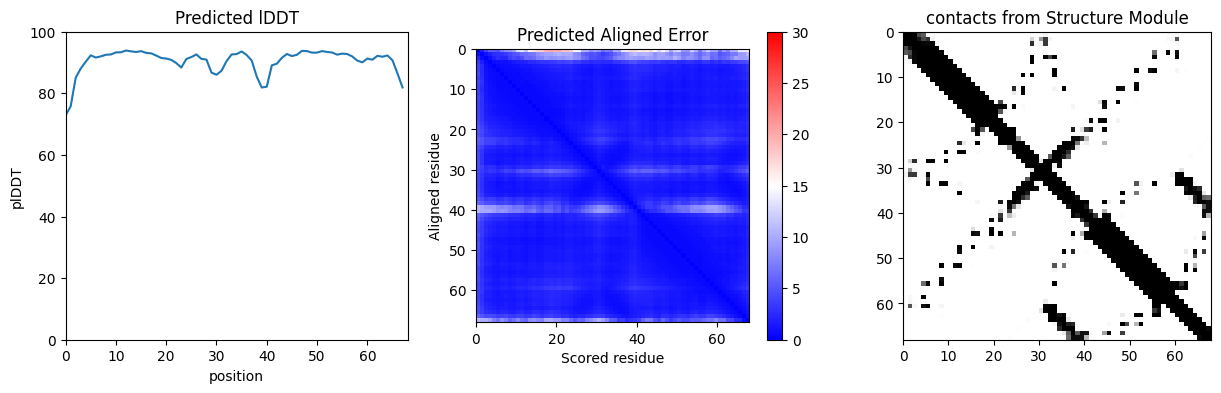

In [ ]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ALPHAFOLD2 PREDICTIONS

